## Solve ODEs with Neural Network
*July 8th, 2024*

[Problem Description](https://www.mathworks.com/help/deeplearning/ug/solve-odes-using-a-neural-network.html) (Mathworks)

In [3]:
import math
import torch
import numpy as np
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ConstantLR

# Learning Parameters
batch_size = 100                # Amount of Training observations per batch
ic_coeff = 7                    # Initial condition Coefficient
momentum = 0.9                  # Accelerate optimization during training
num_epochs = 15                 # Number of Epochs for training phase

initial_learn_rate = 0.05       # Learning rate employed at the beginning of training
learn_rate_drop_period = 5      # Period of epochs needed to update the learning parameter
learn_rate_drop_factor = 0.5    # Multiplies learning rate each period

In [4]:
# Get Device for Training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:
# Neural Network Architecture
class ODE_NeuralNetwork(nn.Module):
    def __init__(self, hidden_size, output_size=1, input_size=1) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [6]:
# Instance of neural network and Display network structure
model = ODE_NeuralNetwork(hidden_size=10).to(device)
model

ODE_NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [5]:
# Training Dataset
X_train = np.linspace(0, 2, 10000, dtype=np.float32)
Xtrain_tensor = torch.from_numpy(X_train).reshape(len(X_train), 1).to(device)
Xtrain_tensor.requires_grad_(True)

train_dataloader = DataLoader(Xtrain_tensor, batch_size=batch_size, shuffle=True)

# Test Dataset
X_test = np.linspace(0, 4, 1000, dtype=np.float32)
Xtest_tensor = torch.from_numpy(X_test).reshape(len(X_test), 1).to(device)

In [26]:
# Loss function and Optimizer definition
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=initial_learn_rate, momentum=momentum)
scheduler = ConstantLR(optimizer, 0.5)

In [27]:
print(model._parameters.items())

odict_items([])


In [7]:
# Training Loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_dataloader:
        # Forward pass
        y = model(batch)

        # Calculate the derivative of the forward pass w.r.t the batch input (x)
        dy = torch.autograd.grad(y,
                                batch,
                                grad_outputs=torch.ones_like(y),
                                retain_graph=True)[0]
        
        # Define differential equation and calculate the loss
        loss_DE = dy + 2 * y * batch

        # Define the initial condition loss
        loss_IC = model(torch.tensor([[0.0]]).to(device)) - 1

        loss = criterion(loss_DE, torch.zeros(batch_size, 1).to(device)) + ic_coeff * criterion(loss_IC, torch.zeros(1, 1).to(device))

        # Backward pass and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Updates the loss per batch
        running_loss += loss.item()
    
    # Update the optimizer's learning rate whenever the epoch is a multiple of 5
    if (epoch % learn_rate_drop_period == 0):
        scheduler.step()

    print(f"Epoch {epoch + 1} | Loss: {running_loss}")

Epoch 1, Loss: 39.876240123063326
Epoch 2, Loss: 2.4165391232818365
Epoch 3, Loss: 2.8761438690125942
Epoch 4, Loss: 3.117297148332
Epoch 5, Loss: 3.1259804721921682
Epoch 6, Loss: 3.0810232777148485
Epoch 7, Loss: 3.019277287647128
Epoch 8, Loss: 2.9591525588184595
Epoch 9, Loss: 2.9265467766672373
Epoch 10, Loss: 2.892811443656683
Epoch 11, Loss: 2.842962769791484
Epoch 12, Loss: 2.83679623529315
Epoch 13, Loss: 2.8173733185976744
Epoch 14, Loss: 2.7780688665807247
Epoch 15, Loss: 2.770585970953107


In [8]:
# Once the model is trained, we perform predictions through the test data
preds = []
with torch.no_grad():
    for input in Xtest_tensor:
        outputs = model(input)
        preds.append(outputs.cpu().detach().numpy()[0])

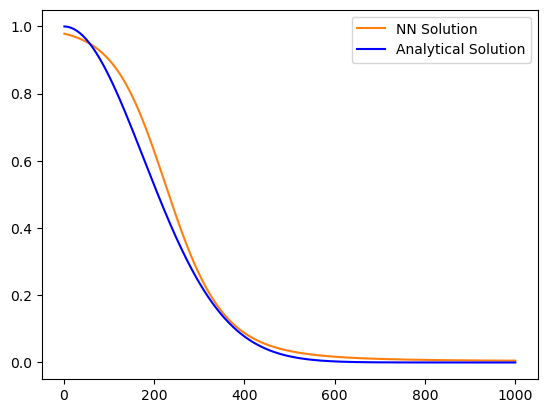

In [21]:
x = np.linspace(1, 1000, num=1000, dtype=np.int32)
y_analytical = [np.exp(-math.pow(x/250, 2)) for x in range(1, 1001)]

plt.plot(x, preds, "tab:orange", label="NN Solution")
plt.plot(x, y_analytical, "b", label="Analytical Solution")
plt.legend(loc="upper right")
plt.show()